<a href="https://colab.research.google.com/github/jhihan/Store-Item-Demand-Forecasting-Challenge/blob/master/Store_Item_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from google.colab import files

In [152]:
uploaded=files.upload()

Saving test.csv to test (1).csv


In [0]:
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv") 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

In [0]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [156]:
test.columns

Index(['id', 'date', 'store', 'item'], dtype='object')

In [157]:
train.columns

Index(['date', 'store', 'item', 'sales'], dtype='object')

In [158]:
print(train.shape,test.shape)

(913000, 4) (45000, 4)


In [159]:
test.tail()

,id,date,store,item
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50
44999,44999,2018-03-31,10,50


In [160]:
print('store'	, ' values: ', train['store'].unique())
print('item'	, ' values: ', train['item'].unique())
print('store'	, ' values: ', test['store'].unique())
print('item'	, ' values: ', test['item'].unique())

store  values:  [ 1  2  3  4  5  6  7  8  9 10]
item  values:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
store  values:  [ 1  2  3  4  5  6  7  8  9 10]
item  values:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


Because 10 * 50 * (365 + 365 + 365 + 366 +365) = 913000.
We know that the train data of (date , store , item) is complate during 2013 -2017
The test data of (date , store , item) is complete during 2018.01.01 - 2018.03.31

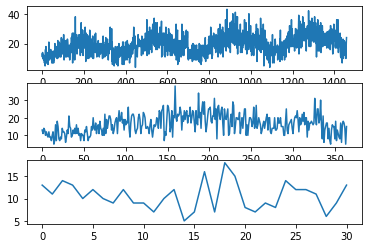

In [161]:
# Check the data the seasonality of the data.

#series = np.array((train.sales[:365*4]))
#time = np.array(train.date_order[:365*4])
plt.subplot(3, 1, 1)
plt.plot(train.sales[:365*4])
plt.subplot(3, 1, 2)
plt.plot(train.sales[:365])

plt.subplot(3, 1, 3)
plt.plot(train.sales[:31])
plt.show()

# There are very strong seasonality and the feature space is very large.
# According to the datascience,stackexchange https://datascience.stackexchange.com/questions/36247/lstm-model-for-predicting-the-minutely-seasonal-data-of-the-day
# and the book François Chollet's book on deep learning, may complex neural net models like LSTM are not great to learn this kind of very long term dependency.
# I also tried the LSTM and found it not performing well......
# I decide to drop the neural network amwthod and use XGBoost.

There are very strong seasonality and the feature space is very large.
According to the datascience.stackexchange https://datascience.stackexchange.com/questions/36247/lstm-model-for-predicting-the-minutely-seasonal-data-of-the-day and the book François Chollet's book on deep learning, may complex neural net models like LSTM are not great to learn this kind of very long term dependency.
I also tried the LSTM and found it not performing well......
I decide to drop the neural network amwthod and use XGBoost.

In [162]:
rolling_mean = train.sales.rolling(window=7).mean()
print(rolling_mean.shape)
print(rolling_mean[:31])

(913000,)
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6     11.857143
7     11.285714
8     11.428571
9     10.714286
10    10.142857
11     9.714286
12     9.428571
13     9.714286
14     9.142857
15     8.428571
16     9.428571
17     9.142857
18    10.714286
19    11.428571
20    10.857143
21    11.142857
22    11.428571
23    10.285714
24    11.285714
25    10.428571
26    10.000000
27    10.428571
28    10.285714
29    10.285714
30    11.000000
Name: sales, dtype: float64


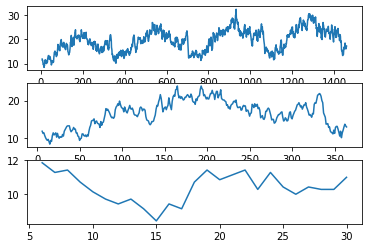

In [163]:
rolling_mean = train.sales.rolling(window=7).mean()
plt.subplot(3, 1, 1)
plt.plot(rolling_mean[:365*4])
plt.subplot(3, 1, 2)
plt.plot(rolling_mean[:365])

plt.subplot(3, 1, 3)
plt.plot(rolling_mean[:31])
plt.show()

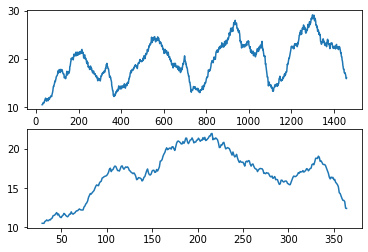

In [164]:
rolling_mean2 = train.sales.rolling(window=30).mean()
plt.subplot(2, 1, 1)
plt.plot(rolling_mean2[:365*4])
plt.subplot(2, 1, 2)
plt.plot(rolling_mean2[:365])
plt.show()

In [165]:
# Combine the train and test data


data_combine = pd.concat([train,test])

print("size of data_combine",data_combine.shape)

size of data_combine (958000, 5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
data_combine['date'] = pd.to_datetime(data_combine['date'],infer_datetime_format=True)


data_combine['month'] = data_combine['date'].dt.month
data_combine['weekday'] = data_combine['date'].dt.dayofweek
data_combine['year'] = data_combine['date'].dt.year
# df['date'].dt.
data_combine['week_of_year']  = data_combine.date.dt.weekofyear

In [0]:
data_combine['date_order'] = (data_combine['date'] - datetime.datetime(2013, 1, 1)).dt.days

In [212]:
data_combine.head(100)

,date,id,item,sales,store,month,weekday,year,week_of_year,date_order,sale_moving_average_7days,sale_moving_average_7days_shifted-90
0,2013-01-01,NaN,1,13.0,1,1,1,2013,1,0,13.000000,NaN
1,2013-01-02,NaN,1,11.0,1,1,2,2013,1,1,12.000000,NaN
2,2013-01-03,NaN,1,14.0,1,1,3,2013,1,2,12.666667,NaN
3,2013-01-04,NaN,1,13.0,1,1,4,2013,1,3,12.750000,NaN
4,2013-01-05,NaN,1,10.0,1,1,5,2013,1,4,12.200000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2013-04-06,NaN,1,23.0,1,4,5,2013,14,95,19.142857,12.166667
96,2013-04-07,NaN,1,17.0,1,4,6,2013,14,96,18.714286,11.857143
97,2013-04-08,NaN,1,19.0,1,4,0,2013,15,97,19.857143,11.285714
98,2013-04-09,NaN,1,13.0,1,4,1,2013,15,98,19.000000,11.428571


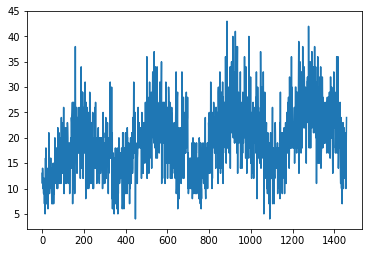

In [0]:
data_combine['sale_moving_average_7days']=data_combine.groupby(["item","store"])['sales'].transform(lambda x: x.rolling(window=7,min_periods=1).mean())
data_combine['sale_moving_average_7days_shifted-90']=data_combine.groupby(["item","store"])['sale_moving_average_7days'].transform(lambda x:x.shift(90))

In [0]:
data_combine['store_item_shifted-90'] = data_combine.groupby(["item","store"])['sales'].transform(lambda x:x.shift(90))
#data_list2=data_combine.groupby(["item","store"])['sales'].transform(lambda x:x.shift(90))
#print(data_list2)

0        13.3
1         9.9
2        12.7
3        14.5
4        14.9
         ... 
44995     NaN
44996     NaN
44997     NaN
44998     NaN
44999     NaN
Name: sales, Length: 958000, dtype: float64


In [170]:
data_combine.head(n=40)

,date,id,item,sales,store,month,weekday,year,week_of_year,date_order,sale_moving_average_7days,sale_moving_average_7days_shifted-90
0,2013-01-01,NaN,1,13.0,1,1,1,2013,1,0,13.000000,NaN
1,2013-01-02,NaN,1,11.0,1,1,2,2013,1,1,12.000000,NaN
2,2013-01-03,NaN,1,14.0,1,1,3,2013,1,2,12.666667,NaN
3,2013-01-04,NaN,1,13.0,1,1,4,2013,1,3,12.750000,NaN
4,2013-01-05,NaN,1,10.0,1,1,5,2013,1,4,12.200000,NaN
5,2013-01-06,NaN,1,12.0,1,1,6,2013,1,5,12.166667,NaN
6,2013-01-07,NaN,1,10.0,1,1,0,2013,2,6,11.857143,NaN
7,2013-01-08,NaN,1,9.0,1,1,1,2013,2,7,11.285714,NaN
8,2013-01-09,NaN,1,12.0,1,1,2,2013,2,8,11.428571,NaN
9,2013-01-10,NaN,1,9.0,1,1,3,2013,2,9,10.714286,NaN


In [0]:
data_combine['store_item_shifted-10'] = data_combine.groupby(["item","store"])['sales'].transform(lambda x:x.shift(10))

In [171]:
data_combine.head(n=40)

,date,id,item,sales,store,month,weekday,year,week_of_year,date_order,sale_moving_average_7days,sale_moving_average_7days_shifted-90
0,2013-01-01,NaN,1,13.0,1,1,1,2013,1,0,13.000000,NaN
1,2013-01-02,NaN,1,11.0,1,1,2,2013,1,1,12.000000,NaN
2,2013-01-03,NaN,1,14.0,1,1,3,2013,1,2,12.666667,NaN
3,2013-01-04,NaN,1,13.0,1,1,4,2013,1,3,12.750000,NaN
4,2013-01-05,NaN,1,10.0,1,1,5,2013,1,4,12.200000,NaN
5,2013-01-06,NaN,1,12.0,1,1,6,2013,1,5,12.166667,NaN
6,2013-01-07,NaN,1,10.0,1,1,0,2013,2,6,11.857143,NaN
7,2013-01-08,NaN,1,9.0,1,1,1,2013,2,7,11.285714,NaN
8,2013-01-09,NaN,1,12.0,1,1,2,2013,2,8,11.428571,NaN
9,2013-01-10,NaN,1,9.0,1,1,3,2013,2,9,10.714286,NaN


In [0]:
data_combine.tail(n=40)

In [0]:
col = [i for i in data_combine.columns if i not in ['date','id','sale_moving_average_7days']]
y_target = train.sales

In [196]:
train_new = data_combine.loc[~data_combine.sales.isna()]
print("new train",train_new.shape)
test_new = data_combine.loc[data_combine.sales.isna()]
print("new test",test_new.shape)

new train (913000, 12)
new test (45000, 12)


In [0]:
train_new = (train_new[col]).dropna()

In [198]:
print(train_new.shape)

(868000, 9)


In [0]:
y_target = train_new.sales
col = [i for i in data_combine.columns if i not in ['date','id','sales','sale_moving_average_7days']]

In [0]:

X_train, X_test, y_train, y_test = train_test_split( train_new[col] ,train_new.sales, test_size=0.15, random_state=42)

In [202]:
y_train.head()

846410    24.0
270438    79.0
603804    26.0
309079    35.0
212152    21.0
Name: sales, dtype: float64

In [204]:
model_sets=[]
for max_depth in range(4,17,3):
  xgb_model = xgb.XGBRegressor(max_depth=max_depth ,min_child_weight=1)
#xgb_model.fit(X_train,y_train,eval_metric='mae')
  xgb_model.fit(X_train,y_train.values,eval_metric=smape)
  model_sets.append(xgb_model)
  
  y_train_pred_xgb=xgb_model.predict(X_train)
  y_test_pred_xgb=xgb_model.predict(X_test)
  print('smape error: max_depth=', max_depth ,',train:' , smape(y_train.values,y_train_pred_xgb),'test:',smape(y_test.values,y_test_pred_xgb))
  print('MSE train:' , mean_absolute_error(np.log1p(y_train),np.log1p(y_train_pred_xgb)),'test:',mean_absolute_error(np.log1p(y_test),np.log1p(y_test_pred_xgb)))

[22:09:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
smape error: max_depth= 4 ,train: 13.470662403037903 test: 13.513300116835929
MSE train: 0.1315106978097518 test: 0.1319403166320611
[22:10:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
smape error: max_depth= 7 ,train: 13.106213092288414 test: 13.205336485736614
MSE train: 0.12791010080365564 test: 0.12889973840242328
[22:12:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
smape error: max_depth= 10 ,train: 12.60687295878863 test: 13.092730439629367
MSE train: 0.12297162285485277 test: 0.1277831532386084
[22:15:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
smape error: max_depth= 13 ,train: 11.129720373074823 test: 13.142426439548496
MSE train: 

In [211]:
#xgb_model = xgb.XGBRegressor(max_depth=6,min_child_weight=1)
#xgb_model.fit(X_train,y_train,eval_metric='mae')
model_sets[2]
model_sets[2].fit(train_new[col],y_target,eval_metric=smape)

y_train_pred_xgb=model_sets[2].predict(X_train)
y_test_pred_xgb=model_sets[2].predict(X_test)
print('smape error: max_depth=', max_depth ,',train:' , smape(y_train.values,y_train_pred_xgb),'test:',smape(y_test.values,y_test_pred_xgb))
print('MSE train:' , mean_absolute_error(np.log1p(y_train),np.log1p(y_train_pred_xgb)),'test:',mean_absolute_error(np.log1p(y_test),np.log1p(y_test_pred_xgb)))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[22:47:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
smape error: max_depth= 16 ,train: 12.658521064806813 test: 12.67410213465026
MSE train: 0.1234825895211898 test: 0.1236437240345655


In [0]:
# Choose the model which provides less smape
y_submission=np.rint(model_sets[2].predict(test_new[col]))
#y_submission=xgb_model.predict(test_new[col])

In [0]:
final = pd.DataFrame(list(zip(test_new['id'], y_submission)), 
               columns =['id', 'sales']) 

In [0]:
final.id = final.id.astype(int)
final.sales = final.sales.astype(int)

In [208]:
final.head(n=20)

,id,sales
0,0,12
1,1,15
2,2,14
3,3,13
4,4,16
5,5,19
6,6,18
7,7,12
8,8,14
9,9,13


In [0]:
final.to_csv("submission.csv",sep=',', index=False)

In [0]:
y_submission=xgb_model.predict(test[col])